# Image Augmentation 
### Setup
- pillow

### Import der Bibliotheken

In [3]:
import urllib

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import numpy as np


## Inhaltsverzeichnis
<ol>
    <li><a href="#einleitung">Einleitung</a></li>
    <li><a href="#schluss">Schlussteil</a></li>
    <li><a href="#quellen">Quellenverzeichnis</a></li>
</ol>

## Einleitung <div id="einleitung" />
- Probleme mit zu kleinem Datenset => führte zu Overfitting
- wie man Overfitting erkennt
- welche Maßnahmen es gegen Overfitting gibt

Da wir Probleme mit dem Datensatz in unserem Projekt "Dogspiracy" hatten, haben wir uns überlegt das Thema Image Augmentation genauer zu betrachten.
Der Hunderassen-Datensatz hat leider nicht den gewünschten Umfang, um erfolgreich Hunderassen klassifizieren zu können. 
Da kein anderer Datensatz zur Verfügung steht und das Problem somit nicht mit dem Einsatz eines größeren Datensatzes gelöst werden kann,
müssen andere Lösungen evaluiert werden. Durch Internetrecherche sind wir auf einen Artikel gestoßen, der uns darauf hingewiesen hat
die Lernkurven genauer zu betrachten. Bei der Betrachtung ist uns aufgefallen, dass die Lernkurven auf Overfitting hindeuten.

Overfitting wird in dem Artikel wie folgt beschrieben:
"Overfitting refers to a model that has learned the training dataset too well, including the statistical noise or random fluctuations in the training dataset."
"Overfitting bezieht sich auf ein Model, das den Trainingsdatensatz zu gut gelernt hat, einschließlich des statistischen Rauschens oder zufälliger Schwankungen im Trainingsdatensatz."

Das Problem beim Overfitting liegt darin, dass je spezialisierter das Modell im Hinblick auf die Trainingsdaten ist, desto weniger
gut kann es auf neue Daten generalisiert werden. 

![test](../assets/overfitting.jpeg)
_Abbildung 1: Beispielkurve für Overfitting aus dem Training für Hunderassenklassifizierung_

## Beispiel Image Augmentation mit Tensorflow

Importieren einen Bildes

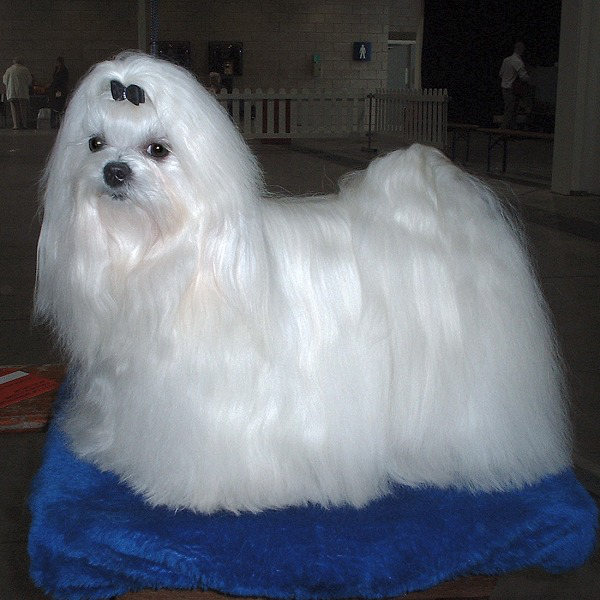

In [4]:
image_path = tf.keras.utils.get_file("good_boy.jpg", "https://raw.githubusercontent.com/MajusLenz/Dogspiracy-machine-learning/master/data/images/predict/good_boy.jpg")
Image.open(image_path)


Das Bild wird in Tensorflow Format konvertiert:

In [5]:
image_string=tf.io.read_file(image_path)
image=tf.image.decode_jpeg(image_string,channels=3)

Über eine Funktion kann das Originalbild mit dem augmentierten Bild verglichen werden:

In [6]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)


Das Bild drehen:

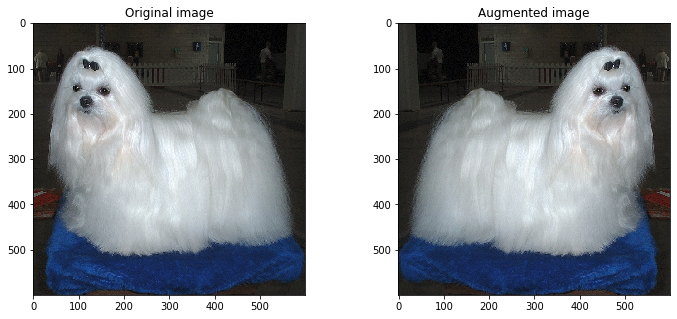

In [7]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

Saturation

In [ ]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)


Helligkeit:

In [ ]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

Kontrast:

In [ ]:
contrast = tf.image.adjust_contrast(image, 2)
visualize(image, contrast)

Rotation

In [ ]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

Crop

In [ ]:
cropped = tf.image.central_crop(image, central_fraction=0.6)
visualize(image,cropped)


In [ ]:
quality = tf.image.adjust_jpeg_quality(image, 20)
visualize(image,quality)


## Schlussteil <div id="schluss" />

## Quellenverzeichnis <div id="quellen" />
- https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
- https://www.tensorflow.org/tutorials/images/data_augmentation